# Support Vector Machine (SVM) Model

This notebook implements and evaluates a Support Vector Machine classifier for Alzheimer's disease prediction. 

## Key Features:
- **Algorithm**: Support Vector Machine with RBF/Linear kernels
- **Preprocessing**: Standard scaling pipeline for feature normalization
- **Hyperparameter Tuning**: GridSearchCV with cross-validation
- **Evaluation**: Comprehensive metrics, confusion matrices, and ROC curves

## Model Overview:
SVM finds the optimal hyperplane to separate classes by maximizing the margin between them. It's effective for high-dimensional data and can handle non-linear relationships using kernel tricks.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import os

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    RocCurveDisplay, ConfusionMatrixDisplay
)

## 1. Data Loading

Loading the preprocessed and split dataset from the preprocessing phase. The data includes:
- **Training set**: Used for model training and hyperparameter tuning
- **Validation set**: Used for model evaluation during development  
- **Test set**: Final evaluation on unseen data

All features have been preprocessed, encoded, and are ready for ML algorithms.

In [37]:
# Load preprocessed data
X_train = joblib.load('../outputs/preprocessed/X_train.pkl')
X_val = joblib.load('../outputs/preprocessed/X_val.pkl')
X_test = joblib.load('../outputs/preprocessed/X_test.pkl')
y_train = joblib.load('../outputs/preprocessed/y_train.pkl')
y_val = joblib.load('../outputs/preprocessed/y_val.pkl')
y_test = joblib.load('../outputs/preprocessed/y_test.pkl')

print("Data loaded successfully!")
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Data loaded successfully!
Train shape: (1944, 14)
Validation shape: (417, 14)
Test shape: (417, 14)


In [38]:
def evaluate_model(model, X_val, y_val, model_name="Model"):
    start_pred = time.time()
    y_pred = model.predict(X_val)
    end_pred = time.time()
    
    metrics = {
        "Accuracy": accuracy_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "F1 Score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_pred),
        "Prediction Time (s)": end_pred - start_pred
    }
    
    print(f"\n{model_name} Evaluation Results:")
    print(pd.DataFrame(metrics, index=[0]))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alzheimer', 'Alzheimer'])
    disp.plot(cmap='Reds', values_format='d')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_val, y_val)
    plt.title(f'{model_name} ROC Curve')
    plt.show()
    
    return y_pred, metrics

## 2. Training Phase - SVM Model

### Hyperparameter Tuning Strategy:
- **C parameter**: Controls regularization (0.1, 1, 10) - balance between smooth decision boundary and classifying training points correctly
- **Kernel**: Linear vs RBF - linear for linearly separable data, RBF for complex non-linear patterns  
- **Gamma**: Kernel coefficient for RBF - controls influence of single training examples

### Pipeline Approach:
1. **StandardScaler**: Normalizes features to zero mean and unit variance (essential for SVM)
2. **SVM Classifier**: Applies the support vector machine algorithm

GridSearchCV with 5-fold cross-validation finds the best combination of hyperparameters.

In [39]:
# SVM with Pipeline and GridSearch
print("Training SVM with GridSearchCV...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, random_state=42))
])

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

start_time = time.time()
svm_grid.fit(X_train, y_train)
end_time = time.time()

print(f"Training completed in {end_time - start_time:.2f} seconds")
print(f"Best parameters: {svm_grid.best_params_}")
print(f"Best cross-validation score: {svm_grid.best_score_:.4f}")

# Get best model
best_svm = svm_grid.best_estimator_

Training SVM with GridSearchCV...
Training completed in 16.07 seconds
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9204
Training completed in 16.07 seconds
Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score: 0.9204



SVM (Validation) Evaluation Results:
   Accuracy  Precision    Recall  F1 Score   ROC-AUC  Prediction Time (s)
0  0.841727   0.832558  0.856459   0.84434  0.841691             0.050398

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       208
           1       0.83      0.86      0.84       209

    accuracy                           0.84       417
   macro avg       0.84      0.84      0.84       417
weighted avg       0.84      0.84      0.84       417



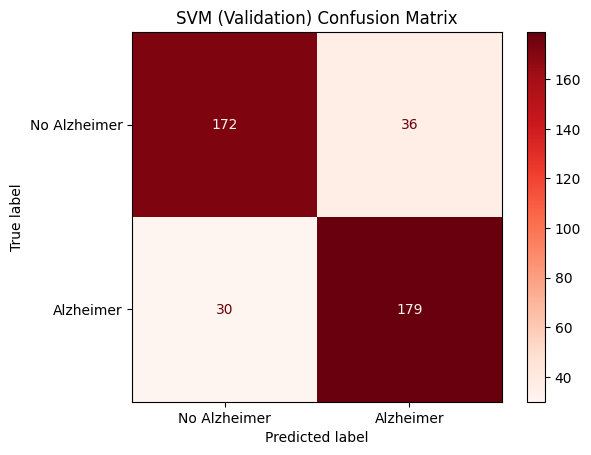

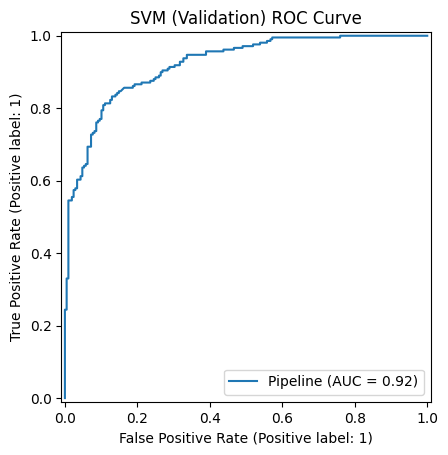

In [40]:
# Evaluate on validation set
y_pred_val, metrics_val = evaluate_model(best_svm, X_val, y_val, "SVM (Validation)")

## 3. Testing Phase - SVM Model

### Final Model Evaluation:
After selecting the best hyperparameters through cross-validation, we evaluate the model on the held-out test set to get unbiased performance estimates.

### Evaluation Metrics:
- **Accuracy**: Overall classification correctness
- **Precision**: Of predicted Alzheimer cases, how many are actually positive
- **Recall**: Of actual Alzheimer cases, how many were correctly identified  
- **F1-Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the ROC curve, measures discrimination ability

### Visualization:
- **Confusion Matrix**: Shows true vs predicted classifications
- **ROC Curve**: Plots true positive rate vs false positive rate

In [41]:
# Test on test set
y_pred_test = best_svm.predict(X_test)
y_proba_test = best_svm.predict_proba(X_test)[:, 1]

print("SVM - Test Set Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_test))

print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

SVM - Test Set Results:
Accuracy: 0.8609112709832134
Precision: 0.8472222222222222
Recall: 0.8798076923076923
F1 Score: 0.8632075471698113
ROC-AUC: 0.9209376150165622

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86       209
           1       0.85      0.88      0.86       208

    accuracy                           0.86       417
   macro avg       0.86      0.86      0.86       417
weighted avg       0.86      0.86      0.86       417



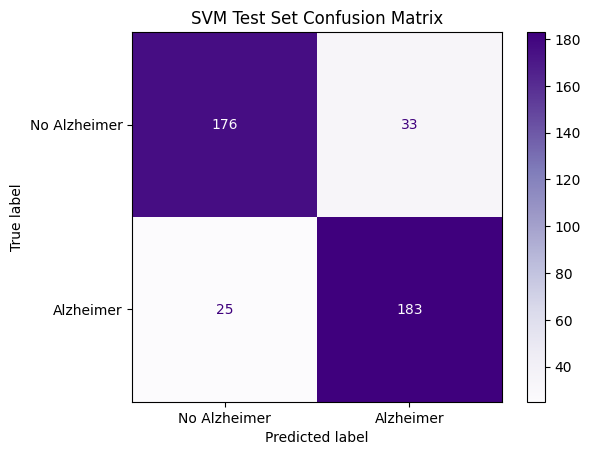

In [42]:
# Confusion Matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Alzheimer', 'Alzheimer'])
disp.plot(cmap='Purples', values_format='d')
plt.title('SVM Test Set Confusion Matrix')
plt.show()

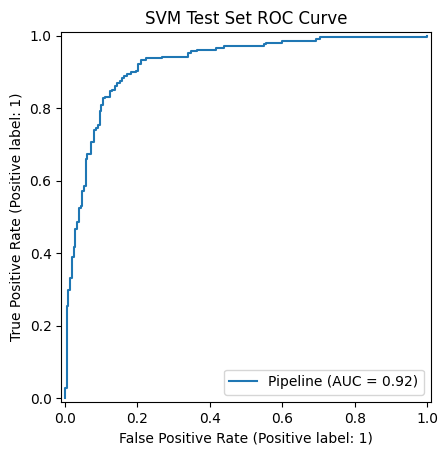

In [43]:
# ROC Curve for test set
RocCurveDisplay.from_estimator(best_svm, X_test, y_test)
plt.title('SVM Test Set ROC Curve')
plt.show()

### Feature Importance Analysis

SVM feature importance depends on the kernel type selected by GridSearchCV:

**Linear Kernel**:
- Creates a straight decision boundary in the original feature space
- Provides direct feature weights from the `coef_` attribute
- Each weight shows how much that feature contributes to the classification
- Easier to interpret but may miss non-linear patterns

**RBF (Radial Basis Function) Kernel**:
- Maps data to higher-dimensional space using Gaussian functions
- Can capture complex non-linear relationships between features  
- No direct feature weights available due to kernel transformation
- **Solution**: Use permutation importance to measure feature contribution

**Permutation Importance**: 
- Works with any kernel type (model-agnostic approach)
- Measures how much model performance drops when each feature is randomly shuffled
- Higher importance = bigger performance drop when feature is removed
- Provides reliable feature rankings for both linear and non-linear models

The analysis below automatically adapts based on the selected kernel.

SVM uses rbf kernel - using permutation importance...


C:\Users\Sana\AppData\Local\Temp\ipykernel_4328\4189299629.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='plasma')


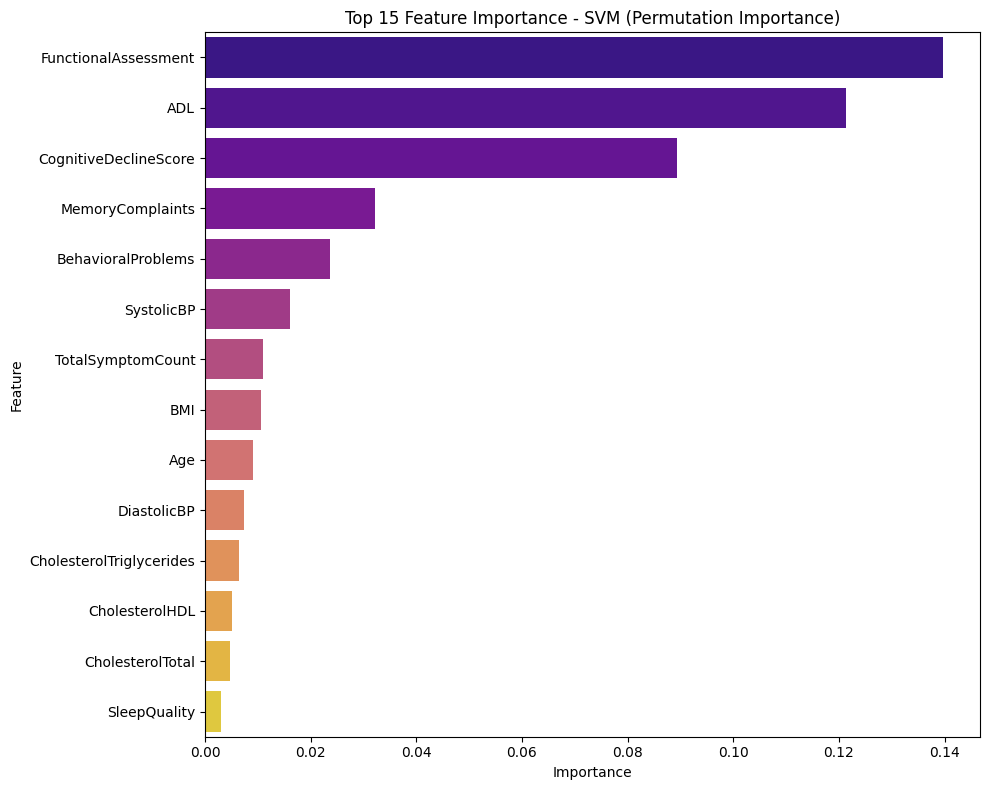

Top 10 Most Important Features (SVM - Permutation Importance):
                  Feature  Importance     Std
8    FunctionalAssessment      0.1397  0.0030
11                    ADL      0.1214  0.0145
12  CognitiveDeclineScore      0.0893  0.0128
9        MemoryComplaints      0.0321  0.0061
10     BehavioralProblems      0.0236  0.0040
3              SystolicBP      0.0160  0.0060
13      TotalSymptomCount      0.0109  0.0048
1                     BMI      0.0105  0.0066
0                     Age      0.0092  0.0031
4             DiastolicBP      0.0073  0.0030


In [44]:
# Feature importance analysis
from sklearn.inspection import permutation_importance

if best_svm.named_steps['svm'].kernel == 'linear':
    # For linear kernel: use direct feature weights
    feature_weights = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(best_svm.named_steps['svm'].coef_[0])
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_weights.head(15), x='Importance', y='Feature', palette='plasma')
    plt.title('Top 15 Feature Weights - SVM (Linear Kernel)')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features (Linear SVM):")
    print(feature_weights.head(10))
    
else:
    # For RBF kernel: use permutation importance
    print(f"SVM uses {best_svm.named_steps['svm'].kernel} kernel - using permutation importance...")
    
    # Calculate permutation importance on validation set
    perm_importance = permutation_importance(best_svm, X_val, y_val, 
                                           n_repeats=5, random_state=42, 
                                           scoring='roc_auc')
    
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': perm_importance.importances_mean,
        'Std': perm_importance.importances_std
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(15), x='Importance', y='Feature', palette='plasma')
    plt.title('Top 15 Feature Importance - SVM (Permutation Importance)')
    plt.tight_layout()
    plt.show()
    
    print("Top 10 Most Important Features (SVM - Permutation Importance):")
    print(feature_importance.head(10).round(4))

## 4. Model Persistence

Saving the trained SVM model for future use in predictions or model comparisons. The saved model includes:
- Best hyperparameters found through GridSearchCV
- Fitted StandardScaler for consistent preprocessing
- Complete pipeline ready for production use

In [45]:
# Save model to outputs/models folder
os.makedirs('../outputs/models', exist_ok=True)
model_path = '../outputs/models/svm_model.pkl'
joblib.dump(best_svm, model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../outputs/models/svm_model.pkl


## 5. Final Results Summary

The SVM model performance summary for easy comparison with other models:

In [46]:
# Display final metrics for model comparison
print("="*50)
print("SVM MODEL - FINAL PERFORMANCE SUMMARY")  
print("="*50)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_test):.4f}")
print("="*50)

# Create results dataframe for display  
metrics_summary = {
    'Model': ['SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_test)],
    'Precision': [precision_score(y_test, y_pred_test)], 
    'Recall': [recall_score(y_test, y_pred_test)],
    'F1_Score': [f1_score(y_test, y_pred_test)],
    'ROC_AUC': [roc_auc_score(y_test, y_proba_test)]
}

metrics_df = pd.DataFrame(metrics_summary)
print("\nSVM Results:")
print(metrics_df.round(4))


SVM MODEL - FINAL PERFORMANCE SUMMARY
Accuracy:  0.8609
Precision: 0.8472
Recall:    0.8798
F1-Score:  0.8632
ROC-AUC:   0.9209

SVM Results:
  Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC
0   SVM    0.8609     0.8472  0.8798    0.8632   0.9209


In [47]:
# Save results to outputs/results folder
os.makedirs('../outputs/results', exist_ok=True)
metrics_df.to_csv('../outputs/results/svm_metrics_summary.csv', index=False)
print(f"\n✓ Results saved to: outputs/results/svm_metrics_summary.csv")

# Get validation predictions for CSV files
y_pred = best_svm.predict(X_val)
y_pred_proba = best_svm.predict_proba(X_val)
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba[:, 1])

# Save predictions CSV
predictions_df = pd.DataFrame({
    'Actual': y_val,
    'Predicted': y_pred,
    'Prediction_Probability': y_pred_proba[:, 1]  # Probability of positive class
})
predictions_df.to_csv('../outputs/results/svm_predictions.csv', index=False)

# Save validation results CSV
validation_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Value': [accuracy, precision, recall, f1, roc_auc]
})
validation_results.to_csv('../outputs/results/svm_validation_results.csv', index=False)

print("✅ SVM predictions saved to ../outputs/results/svm_predictions.csv")
print("✅ SVM validation results saved to ../outputs/results/svm_validation_results.csv")


✓ Results saved to: outputs/results/svm_metrics_summary.csv
✅ SVM predictions saved to ../outputs/results/svm_predictions.csv
✅ SVM validation results saved to ../outputs/results/svm_validation_results.csv
✅ SVM predictions saved to ../outputs/results/svm_predictions.csv
✅ SVM validation results saved to ../outputs/results/svm_validation_results.csv
